# 5. Computational Problem: Income Prediction

In this problem, we will fit logistic regression models on the [Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult). This is a classical dataset in machine learning where want to predict if an individual in the 1994 US Census earns over \$50K annually. Our goal is to give you some practice with essential aspects of model development and evaluation when building a model that outputs risk predictions. We'll use a processed dataset with binary features to speed things up ([link](https://canvas.ucsd.edu/courses/64955/files/15104778?module_item_id=2771885)), and provide most of the code you need in a starter notebook ([link](https://canvas.ucsd.edu/courses/64955/files/15104780?module_item_id=2771887)).

## Helper Code

Implement L1 Logistic Regression Class's `fit(self, X, y)` function below by modifying the L2 Logistic Regression Class code from Q4. For part (a), you could fit Vanilla Logistic Regression by setting penalty to 0 to the L2 Logistic Regression you implemented in Q4, but you would want to implement this class for part (b) and (c).

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
import numpy as np
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import StratifiedKFold

#### L1 Logistic Regression via CVX
class L1LogisticRegression(object):

    def __init__(self, C = 0.0):
        assert np.greater_equal(C, 0.0)
        self.C = cp.Parameter(nonneg=True)
        self.C.value = C

    # main methods
    def check_data(self, X, y):
        assert X.ndim == 2
        assert X.shape[0] > 0
        assert np.isfinite(X).all()
        assert np.isfinite(y).all()
        assert np.isin(y, (0, 1)).all()
        return True

    def fit(self, X, y):
        """
        :return: coefficients of optimal model
        """
        assert self.check_data(X, y)
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.X = X
        self.y = y
        self.w = cp.Variable(self.d)
        self.t = cp.Variable(1)
        # YOUR CODE HERE
        logistic_loss = cp.sum(
            cp.logistic(-cp.multiply(y, X @ self.w + self.t))
        ) / self.n

        # Define the L1 penalty
        l1_penalty = self.C * cp.norm1(self.w)

        # Define the objective function
        objective = cp.Minimize(logistic_loss + l1_penalty)

        # Define the optimization problem
        self.problem = cp.Problem(objective)
        
        self.problem.solve()

    #### Classifier Properties ###
    @property
    def has_solution(self):
        return self.w.value is not None

    @property
    def intercept(self):
        if self.has_solution:
            return self.t.value
        else:
            return np.nan

    @property
    def coefs(self):
        if self.has_solution:
            return self.w.value
        else:
            return np.repeat(np.nan, self.d)

    #### prediction API ####
    def decision_function(self, X):
        """
        returns confidence score
        :param X:
        :return: vector of confidence scores for each row in X
        """
        scores = X.dot(self.coefs) + self.intercept
        return scores

    def predict_proba(self, X):
        """
        predicts probability of positive class
        :param X: feature matrix with d columns features
        :return: vector of predicted probabilities for each row in X
        """
        scores = self.decision_function(X)
        probs = np.zeros_like(scores)
        pos_idx = np.greater_equal(scores, 0)
        neg_idx = np.logical_not(pos_idx)
        probs[pos_idx] = 1.0 / (1.0 + np.exp(-scores[pos_idx]))
        probs[neg_idx] = np.exp(scores[neg_idx]) / (1.0 + np.exp(scores[neg_idx]))
        return probs

    def predict(self, X):
        """
        predicts label for each row in X
        :param X: feature matrix with d columns features
        :return: vector of confidence scores for each row in X
        """
        probs = self.predict_proba(X)
        yhat = np.greater(probs, 0.5)
        return yhat

#### HELPER FUNCTIONS ####
def compute_log_loss(y_true, y_proba, eps=1e-15):
    """
    computes mean logistic loss using labels and probability predictions
    :param y_true: vector of true labels - y_true[i] in (-1,+1) and y_true[i] (0,1) are both OK
    :param y_proba: vector of predicted probabilities
    :param eps: minimum distance that y_pred must maintain from 0 and 1
    :return: log_loss
    """
    p = np.clip(y_proba, eps, 1.0 - eps)
    y = y_true > 0
    L = y * np.log(p) + (1 - y) * np.log(1.0 - p)
    return -np.mean(L)

def compute_auc(y_true, y_proba):
    """
    computes AUC for a binary classifier quickly
    :param y_true: vector of true classes
    :param y_proba: vector of predicted probabilities
    :return: auc
    """
    n = len(y_true)
    I_pos = y_true > 0
    # if y[i] == 0 for all i or y[i] == 1 for all i, then return AUC = 1
    if I_pos.all() or np.logical_not(I_pos).all():
        return float('nan')

    I_pos = I_pos[np.argsort(y_proba)]
    false_positive_count = np.cumsum(1 - I_pos)
    n_false = false_positive_count[-1]
    auc = np.multiply(I_pos, false_positive_count).sum() / (
            n_false * (n - n_false))
    return auc

def compute_ece(y_true, y_proba, n_bins=10):
    """
    computes expected calibration error for a binary classifier
    :param y_true: vector of true classes
    :param y_proba: vector of predicted probabilities
    :param n_bins: 10
    :return:ece
    """

    # pre-process to improve binning
    sort_idx = np.argsort(y_proba)
    y_pred = y_proba[sort_idx]
    y_true = y_true[sort_idx] > 0
    n = len(y_true)

    acc = np.zeros(n_bins)
    conf = np.zeros(n_bins)
    counts = np.zeros(n_bins)

    for k in range(n_bins):
        left_idx = np.searchsorted(y_pred, k / n_bins, side='left')
        right_idx = np.searchsorted(y_pred, (k + 1) / n_bins, side='right')
        if left_idx < right_idx:
            bin_idx = np.arange(left_idx, right_idx)
            counts[k] = len(bin_idx)
            conf[k] = np.mean(y_pred[bin_idx])
            acc[k] = np.mean(y_true[bin_idx])

    ece = np.sum(counts * np.abs(acc - conf)) / n
    return ece

def plot_roc_curve(y_true, y_pred, ax, type = 'full'):
    """
    :param y_true:
    :param y_pred:
    :param ax:
    :return:
    """
    assert len(y_true) == len(y_pred)

    if type == 'full':
        plot_args = {'color': "black"}
    elif type == 'fold':
        plot_args = {'color': "grey"}

    # call sklearn
    return RocCurveDisplay.from_predictions(y_true, y_pred, ax = ax, **plot_args)

def plot_reliability_diagram(y_true, y_pred, ax, type = 'full', n_bins = 10):
    """
    :param y_true:
    :param y_pred:
    :param ax:
    :return:
    """
    assert len(y_true) == len(y_pred)

    if type == 'full':
        plot_args = {'color': "black"}
    elif type == 'fold':
        plot_args = {'color': "grey"}

    # call sklearn
    return CalibrationDisplay.from_predictions(y_true, y_pred, strategy = 'uniform', ax = ax, n_bins = n_bins, **plot_args)

## Part (a)
Fit a vanilla logistic regression model for this dataset.

- i. Plot an ROC curve and the reliability diagram for your model. Each plot should include 2 lines: (1) to show the performance of the model on the entire training dataset; (1) to show the mean performance across the 5 folds.
- ii. Report the values of the training loss, AUC, and ECE for your model. Compare them to the values mean 5-CV estimates of the loss, AUC, ECE? Given your results, state if we can use the model for ranking and risk estimation on unseen data.

In [20]:
### load dataset
df = pd.read_csv('./data/adult_processed.csv')
variable_names = df.columns.tolist()[1:]
outcome_name = df.columns.tolist()[0]
y = df[outcome_name].values
X = df[variable_names].values

In [21]:
### generate folds first, so we use the same for each trial
kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=1337)
folds = np.repeat(np.nan, X.shape[0])
for k, cv_indices in enumerate(kf.split(X, y)):
    test_indices = cv_indices[1]
    folds[test_indices] = k + 1
folds = folds.astype(int)

#### fit clf for L1 regression
clf = L1LogisticRegression(C = 0.0)
clf.fit(X, y)

# stats for model trained on all data

Predicted probabilities (first 10): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Minimum probability: 0.9999999584781187
Maximum probability: 0.9999999979388463
True labels (first 10): [0 0 0 0 0 0 0 1 1 1]
Unique labels: [0 1]
Training Metrics:
Log Loss: 14.6434, AUC: 0.7670, ECE: 0.7592

Mean 5-CV Metrics:
Log Loss: 14.8625, AUC: 0.7555, ECE: 0.7592


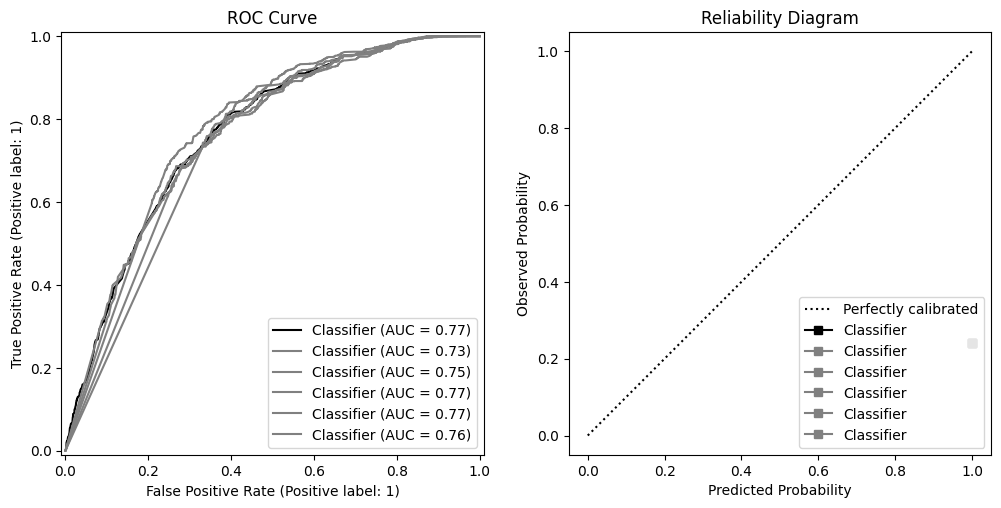

In [22]:
# roc/cal plots for models fit on all the data
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].set_aspect('equal', adjustable='box') # roc curve
ax[1].set_aspect('equal', adjustable='box') # reliability diagram

# Train on the entire dataset
clf = L1LogisticRegression(C=0.0)
clf.fit(X, y)

# Predictions on the entire dataset
y_proba = clf.predict_proba(X)
y_pred = clf.predict(X)

# Compute metrics for the entire dataset
train_loss = compute_log_loss(y, y_proba)
train_auc = compute_auc(y, y_proba)
train_ece = compute_ece(y, y_proba)

# Plot ROC curve and reliability diagram for the entire dataset
plot_roc_curve(y, y_proba, ax[0], type='full')

print("Predicted probabilities (first 10):", y_proba[:10])
print("Minimum probability:", np.min(y_proba))
print("Maximum probability:", np.max(y_proba))
print("True labels (first 10):", y[:10])
print("Unique labels:", np.unique(y))

plot_reliability_diagram(y, y_proba, ax[1], type='full')

# Cross-validation metrics
cv_losses, cv_aucs, cv_eces = [], [], []

for k in range(1, max(folds)+1):

    clf = L1LogisticRegression(C = 0.0)
    test_idx = np.isin(folds, k)
    train_idx = ~test_idx
    clf.fit(X[train_idx], y[train_idx])

    # Predictions on the test fold
    y_proba_fold = clf.predict_proba(X[test_idx])
    y_fold = y[test_idx]

    # Compute metrics for the fold
    cv_losses.append(compute_log_loss(y_fold, y_proba_fold))
    cv_aucs.append(compute_auc(y_fold, y_proba_fold))
    cv_eces.append(compute_ece(y_fold, y_proba_fold))

    # Plot ROC curve and reliability diagram for the fold
    plot_roc_curve(y_fold, y_proba_fold, ax[0], type='fold')
    plot_reliability_diagram(y_fold, y_proba_fold, ax[1], type='fold')

# Compute mean CV metrics
mean_cv_loss = np.mean(cv_losses)
mean_cv_auc = np.mean(cv_aucs)
mean_cv_ece = np.mean(cv_eces)

# Display metrics
print("Training Metrics:")
print(f"Log Loss: {train_loss:.4f}, AUC: {train_auc:.4f}, ECE: {train_ece:.4f}")
print("\nMean 5-CV Metrics:")
print(f"Log Loss: {mean_cv_loss:.4f}, AUC: {mean_cv_auc:.4f}, ECE: {mean_cv_ece:.4f}")

ax[0].set_title("ROC Curve")
ax[1].set_title("Reliability Diagram")
ax[1].set_xlabel("Predicted Probability")
ax[1].set_ylabel("Observed Probability")
plt.show()

## Part (b)
Fit a $L_1$-penalized logistic regression model by adapting your implementation from Problem Q4. Fit models for $L_1$-penalties in the set $\lambda \in \{0.001, 0.002, 0.005, 0.01, 0.02, 0.05\}.$ Instead of tuning the $L_1$-penalty to maximize predictive accuracy, let us tune it to induce sparsity by returning the best possible model with a model size of at most 5. Here, *model size* refers to number of non-zero coefficients in your model excluding the intercept term. *Note: you may run into a numerical issue where **cvxpy** returns small coefficients with very small values, rather than values set to zero. To avoid miscalculating model size in this case, you should manually set any coefficient $|w_j| < 10^{-6}$ to 0.*

- i. Plot an ROC curve and the reliability diagram for your model. Again each plot should include 2 lines: (1) to show the performance of the model on the entire training dataset; (1) to show the mean performance across five folds.

- ii. How does $L_1$-regularization affect calibration? Explain why you observe this effect?

- iii. What is its training loss, AUC, and ECE? What is the 5-CV loss, AUC, and ECE? Can you rely on 5-CV to estimate the performance of your model on unseen data?

Penalty: 0.001
Training Loss: 14.9442, AUC: 0.4991, ECE: 0.7592
Mean 5-CV Loss: 14.8471, AUC: 0.4991, ECE: 0.7592
--------------------------------------------------
Penalty: 0.002
Training Loss: 15.1838, AUC: 0.4991, ECE: 0.7592
Mean 5-CV Loss: 15.0098, AUC: 0.4991, ECE: 0.7592
--------------------------------------------------
Penalty: 0.005
Training Loss: 15.1838, AUC: 0.4991, ECE: 0.7592
Mean 5-CV Loss: 14.9519, AUC: 0.4991, ECE: 0.7592
--------------------------------------------------
Penalty: 0.01
Training Loss: 15.1838, AUC: 0.4991, ECE: 0.7592
Mean 5-CV Loss: 14.8758, AUC: 0.4991, ECE: 0.7592
--------------------------------------------------
Penalty: 0.02
Training Loss: 15.1838, AUC: 0.4991, ECE: 0.7592
Mean 5-CV Loss: 14.8694, AUC: 0.4991, ECE: 0.7592
--------------------------------------------------
Penalty: 0.05
Training Loss: 14.9325, AUC: 0.4991, ECE: 0.7592
Mean 5-CV Loss: 15.0513, AUC: 0.4991, ECE: 0.7592
--------------------------------------------------


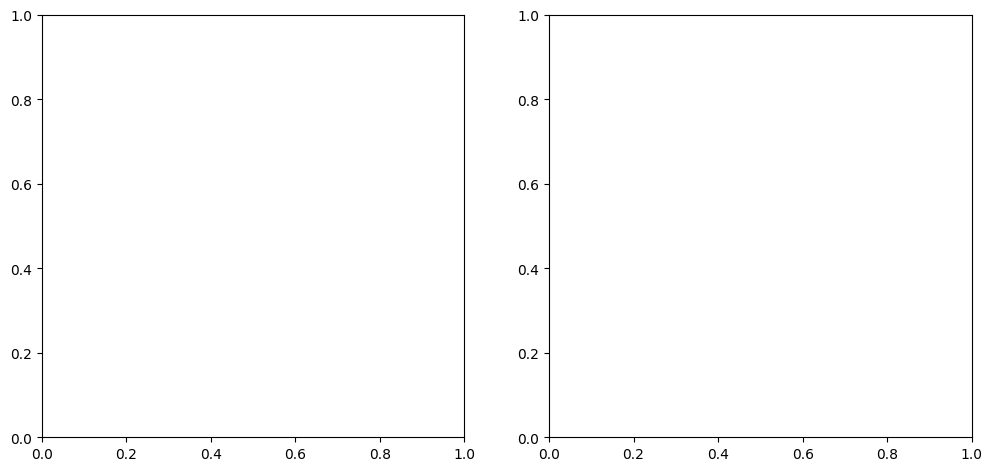

Best model penalty: 0.001
Best model size: 0


In [23]:
##### Fit Classifiers for L1 Logistic Regression #####
best_model = None
best_model_size = float('inf')
best_penalty = None

for penalty in [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]:

    # train full model
    clf = L1LogisticRegression(C = penalty)
    clf.fit(X, y)

    # Set small coefficients to zero
    coefs = clf.coefs
    coefs[np.abs(coefs) < 1e-6] = 0
    model_size = np.sum(coefs != 0)
    
    # Check if the model size is at most 5
    if model_size <= 5 and model_size < best_model_size:
        best_model = clf
        best_model_size = model_size
        best_penalty = penalty
    
    # Predictions on the entire dataset
    y_proba = clf.predict_proba(X)
    
    # Compute metrics for the entire dataset
    train_loss = compute_log_loss(y, y_proba)
    train_auc = compute_auc(y, y_proba)
    train_ece = compute_ece(y, y_proba)
    
    # Plot ROC curve and reliability diagram for the entire dataset
    plot_roc_curve(y, y_proba, ax[0], type='full')
    plot_reliability_diagram(y, y_proba, ax[1], type='full')
    
    # Perform 5-fold cross-validation
    cv_losses, cv_aucs, cv_eces = [], [], []

    # train fold models
    for k in range(1, max(folds) + 1):

        clf = L1LogisticRegression(C = penalty)
        test_idx = np.isin(folds, k)
        train_idx = ~test_idx
        clf.fit(X[train_idx], y[train_idx])

  # Predictions on the test fold
        y_proba_fold = clf.predict_proba(X[test_idx])
        y_fold = y[test_idx]
        
        # Compute metrics for the fold
        cv_losses.append(compute_log_loss(y_fold, y_proba_fold))
        cv_aucs.append(compute_auc(y_fold, y_proba_fold))
        cv_eces.append(compute_ece(y_fold, y_proba_fold))
        
        # Plot ROC curve and reliability diagram for the fold
        plot_roc_curve(y_fold, y_proba_fold, ax[0], type='fold')
        plot_reliability_diagram(y_fold, y_proba_fold, ax[1], type='fold')
    
    # Compute mean CV metrics
    mean_cv_loss = np.mean(cv_losses)
    mean_cv_auc = np.mean(cv_aucs)
    mean_cv_ece = np.mean(cv_eces)

    # Print metrics
    print(f"Penalty: {penalty}")
    print(f"Training Loss: {train_loss:.4f}, AUC: {train_auc:.4f}, ECE: {train_ece:.4f}")
    print(f"Mean 5-CV Loss: {mean_cv_loss:.4f}, AUC: {mean_cv_auc:.4f}, ECE: {mean_cv_ece:.4f}")
    print("-" * 50)

#plot for your chosen model
fig, ax = plt.subplots(1, 2, figsize = (12, 12))
ax[0].set_aspect('equal', adjustable='box') # roc curve
ax[1].set_aspect('equal', adjustable='box') # reliability diagram
plt.show()

# Print the best model details
print(f"Best model penalty: {best_penalty}")
print(f"Best model size: {best_model_size}")

## Part (c)
Let's see if we can improve the probability predictions from your ``sparse" model by Platt Scaling. Fit a vanilla logistic regression model to post-process the probability predictions from your model in part (b) via Platt scaling.

- i. Plot a reliability diagram to show the probabilities of the model trained on the entire training dataset after Platt Scaling. How do the probability predictions compare to the values you obtained in Part (b)?

- ii. How does Platt Scaling affects ECE? What about AUC? Explain your observations.

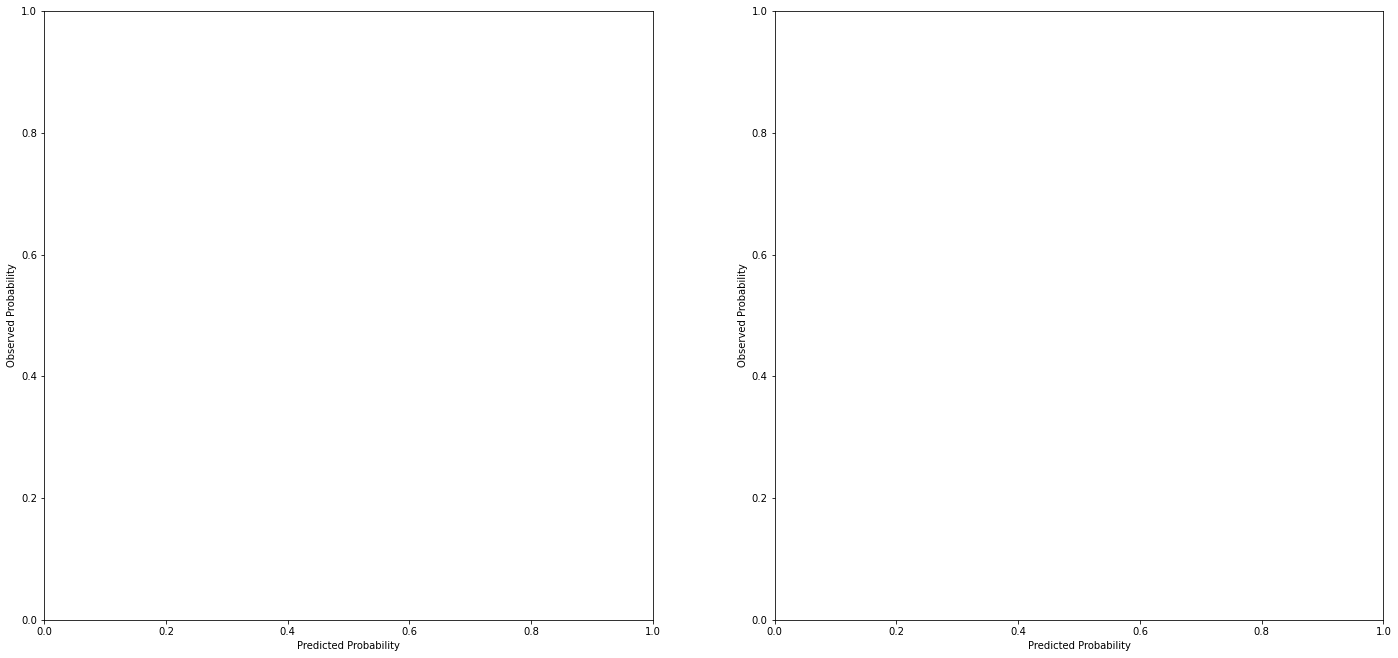

In [ ]:
###### Question 3: Platt Scaling ####

# Your Code Here for Platt Scaling

fig, ax = plt.subplots(1, 2, figsize = (24, 12))
ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')

# Your Code Here
# Use plot_reliability_diagram()

ax[0].set_xlabel("Predicted Probability")
ax[0].set_ylabel("Observed Probability")
ax[1].set_xlabel("Predicted Probability")
ax[1].set_ylabel("Observed Probability")
plt.show()